# Train Denoise Autoencoder on MNIST dataset

## Import libraries and dataset

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from keras.layers.core import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, \
      ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

nb_classes = 10
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

## Add some noise

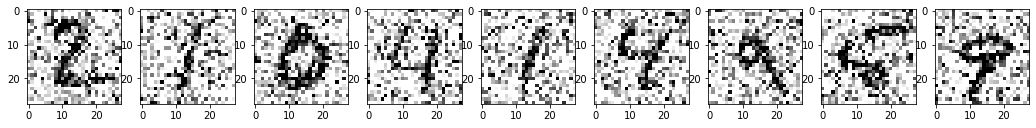

In [3]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

plt.figure(figsize=(20, 2))
for i in range(1, 10):
    ax = plt.subplot(1, 10, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="binary")
plt.show()

## Build, fit and evaluate denoise autoencoder

In [4]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation='relu', padding='same'))

es = EarlyStopping(monitor='val_loss', verbose=1, patience=2)
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         2312      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           5

In [5]:
history = model.fit(x_train_noisy, x_train, epochs=10000, callbacks=[es], 
                    batch_size=256, shuffle=True, 
                    validation_data=(x_test_noisy, x_test))

Epoch 1/10000
235/235 [==============================] - 5s 12ms/step - loss: 0.0529 - val_loss: 0.0402
Epoch 2/10000
235/235 [==============================] - 2s 10ms/step - loss: 0.0365 - val_loss: 0.0330
Epoch 3/10000
235/235 [==============================] - 2s 10ms/step - loss: 0.0314 - val_loss: 0.0293
Epoch 4/10000
235/235 [==============================] - 2s 10ms/step - loss: 0.0287 - val_loss: 0.0280
Epoch 5/10000
235/235 [==============================] - 2s 10ms/step - loss: 0.0272 - val_loss: 0.0275
Epoch 6/10000
235/235 [==============================] - 2s 10ms/step - loss: 0.0261 - val_loss: 0.0250
Epoch 7/10000
235/235 [==============================] - 2s 10ms/step - loss: 0.0251 - val_loss: 0.0244
Epoch 8/10000
235/235 [==============================] - 2s 10ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/10000
235/235 [==============================] - 2s 10ms/step - loss: 0.0238 - val_loss: 0.0232
Epoch 10/10000
235/235 [==============================] - 2s 10m

In [6]:
model.evaluate(x_test_noisy, x_test)

model.save('denoise_autoencoder_model_weights.h5')
print("Model successfully saved!")

313/313 [==============================] - 1s 2ms/step - loss: 0.0197
Model successfully saved!


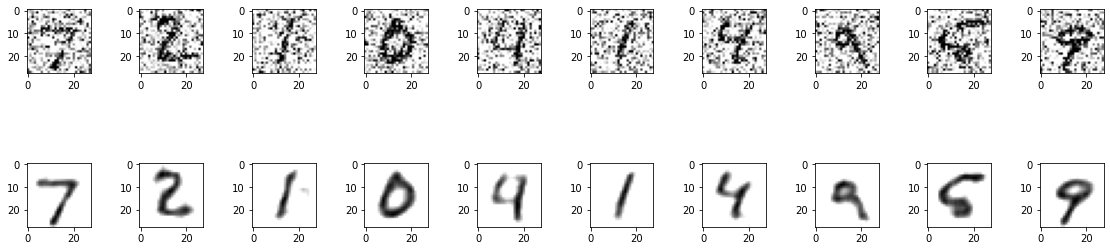

In [7]:
no_noise_img = model.predict(x_test_noisy)

plt.figure(figsize=(40, 4))
for i in range(10):
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="binary")

    ax = plt.subplot(3, 20, 40 + i + 1)
    plt.imshow(no_noise_img[i].reshape(28, 28), cmap="binary")

plt.show()

## Build, fit and evaluate classifier

In [8]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=2)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 10, 10, 64)       

In [9]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, 
                         shear_range=0.3, height_shift_range=0.08, 
                         zoom_range=0.08)
test_gen = ImageDataGenerator()

train_generator = gen.flow(x_train, y_train, batch_size=256)
test_generator = test_gen.flow(x_test, y_test, batch_size=256)

In [10]:
history = model.fit_generator(train_generator, epochs=10000, callbacks=[es], 
                              shuffle=True, validation_data=test_generator)

Epoch 1/10000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


235/235 [==============================] - 18s 72ms/step - loss: 0.1637 - accuracy: 0.9498 - val_loss: 2.2175 - val_accuracy: 0.4037
Epoch 2/10000
235/235 [==============================] - 17s 71ms/step - loss: 0.0550 - accuracy: 0.9833 - val_loss: 0.1101 - val_accuracy: 0.9656
Epoch 3/10000
235/235 [==============================] - 17s 71ms/step - loss: 0.0427 - accuracy: 0.9866 - val_loss: 0.0230 - val_accuracy: 0.9928
Epoch 4/10000
235/235 [==============================] - 17s 71ms/step - loss: 0.0353 - accuracy: 0.9889 - val_loss: 0.0189 - val_accuracy: 0.9929
Epoch 5/10000
235/235 [==============================] - 17s 71ms/step - loss: 0.0300 - accuracy: 0.9901 - val_loss: 0.0224 - val_accuracy: 0.9930
Epoch 6/10000
235/235 [==============================] - 17s 71ms/step - loss: 0.0277 - accuracy: 0.9910 - val_loss: 0.0227 - val_accuracy: 0.9929
Epoch 7/10000
235/235 [==============================] - 17s 70ms/step - loss: 0.0257 - accuracy: 0.9919 - val_loss: 0.0217 - val_ac

## Test classifier on clean, noisy and denoised test datasets

In [11]:
print('Clean test score:')
score = model.evaluate(x_test, y_test)

print('\nNoisy test score:')
score = model.evaluate(x_test_noisy, y_test)

print('\nDenoised test score:')
score = model.evaluate(no_noise_img, y_test)

Clean test score:
313/313 [==============================] - 1s 3ms/step - loss: 0.0217 - accuracy: 0.9930

Noisy test score:
313/313 [==============================] - 1s 3ms/step - loss: 11.6326 - accuracy: 0.0978

Denoised test score:
313/313 [==============================] - 1s 3ms/step - loss: 0.3780 - accuracy: 0.9043
